In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X[:1200] / 255.0
y = LabelEncoder().fit_transform(y[:1200]).astype(np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)

In [ ]:
class Dense:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.1
        self.b = np.zeros(out_dim)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad, lr):
        dW = self.x.T @ grad
        db = np.sum(grad, axis=0)
        dx = grad @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dx

class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, grad, lr):
        return grad * self.mask

class SoftmaxCrossEntropy:
    def forward(self, x, y):
        self.y = y
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        loss = -np.log(self.probs[np.arange(len(y)), y] + 1e-9)
        return np.mean(loss)

    def backward(self, _, lr):
        grad = self.probs
        grad[np.arange(len(self.y)), self.y] -= 1
        return grad / len(self.y)


In [ ]:
class SimpleFNN:
    def __init__(self):
        self.layers = [
            Dense(784, 128),
            ReLU(),
            Dense(128, 64),
            ReLU(),
            Dense(64, 10)
        ]
        self.loss_fn = SoftmaxCrossEntropy()

    def forward(self, x, y):
        for layer in self.layers:
            x = layer.forward(x)
        loss = self.loss_fn.forward(x, y)
        return x, loss

    def backward(self, lr):
        grad = self.loss_fn.backward(None, lr)
        for layer in reversed(self.layers):
            grad = layer.backward(grad, lr)

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return np.argmax(x, axis=1)


In [ ]:
model = SimpleFNN()
epochs = 5
batch_size = 20
lr = 0.01
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    perm = np.random.permutation(len(X_train))
    X_train = X_train[perm]
    y_train = y_train[perm]

    total_loss = 0
    correct = 0
    for i in range(0, len(X_train), batch_size):
        xb = X_train[i:i+batch_size]
        yb = y_train[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        preds = np.argmax(logits, axis=1)
        correct += np.sum(preds == yb)
        total_loss += loss
        model.backward(lr)

    acc = correct / len(X_train)
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")
    train_losses.append(total_loss)
    train_accuracies.append(acc)


Epoch 1, Loss: 114.5972, Accuracy: 0.1940
Epoch 2, Loss: 105.8749, Accuracy: 0.3330
Epoch 3, Loss: 96.9082, Accuracy: 0.4700
Epoch 4, Loss: 86.1118, Accuracy: 0.6050
Epoch 5, Loss: 74.4498, Accuracy: 0.6580


In [ ]:
test_preds = model.predict(X_test)
test_acc = np.mean(test_preds == y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.6850


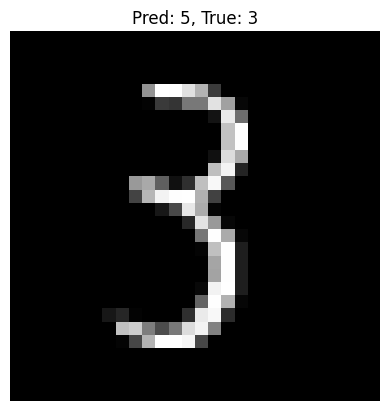

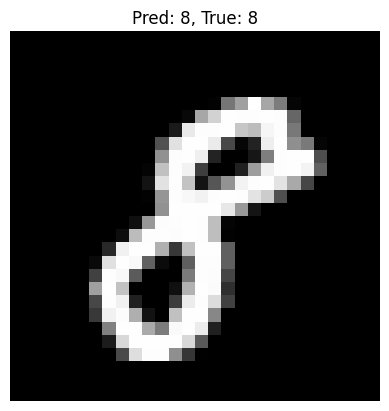

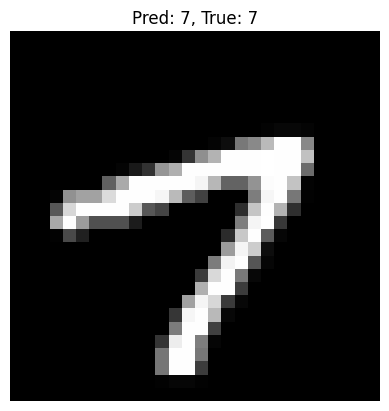

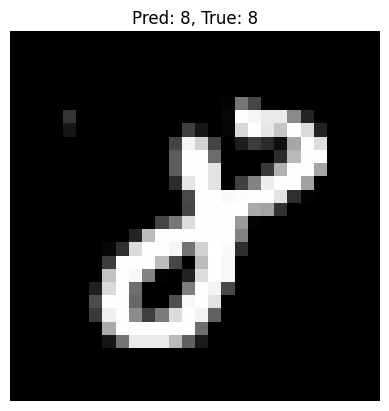

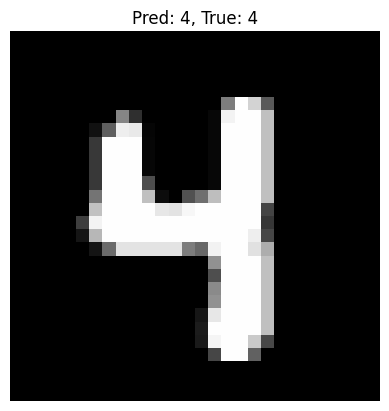

In [ ]:
def show_predictions(model, X, y_true, count=5):
    preds = model.predict(X[:count])
    for i in range(count):
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {preds[i]}, True: {y_true[i]}")
        plt.axis('off')
        plt.show()

show_predictions(model, X_test, y_test)

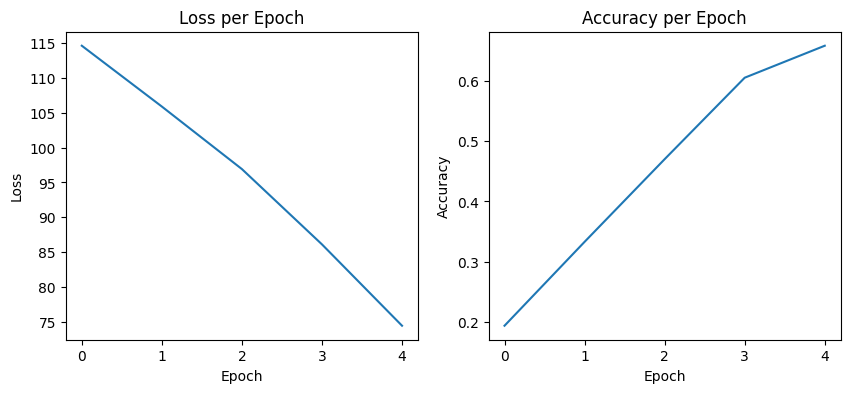

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()